## Жесткая задача Коши

### A- и L- устойчивые методы


Цыбулин Иван ([tsybulin@crec.mipt.ru](mailto:tsybulin@crec.mipt.ru))

### Сравнение методов РК разных порядков

Возьмем в качестве модельной задачи задачу о движении тела в поле Земли и Луны (орбита Аренсторфа)
$$
x'' = x + 2y' - M \frac{x+m}{\sqrt{(x+m)^2 + y^2}^3} - m \frac{x-M}{\sqrt{(x-M)^2 + y^2}^3}\\
y'' = y - 2x' - M \frac{y}{\sqrt{(x+m)^2 + y^2}^3} - m \frac{y}{\sqrt{(x-M)^2 + y^2}^3}\\
m = 0.012277471,\; M = 1 - m\\
x(0) = 0.994,\; y(0) = 0\\
x'(0) = 0, \; y'(0) = -2.001585106379
$$

In [5]:
import numpy as np
# Вычисляет правую часть системы ОДУ
# du/dt = aren(t, u)
def aren(t, u):
    x, y, vx, vy = u
    m = 0.012277471; M = 1 - m
    Dm = ((x+m)**2+y**2)**(1.5);
    De = ((x-M)**2+y**2)**(1.5)
    return np.array([vx, vy,
                x+2*vy-M*(x+m)/Dm-m*(x-M)/De,
                y-2*vx-M*  y  /Dm-m*  y  /De])

aren_init = np.array([0.994, 0, 0, -2.001585106379])
aren_tmax = 17.06521656015796

### Методы

Решать задачу будем явными методами Рунге-Кутты 1го, 2го и 4го порядков со следующими таблицами Бутчера:
$$
\overset{\text{Euler}}{
\begin{array}{c|c}
0 & \\
\hline
& 1
\end{array}}
\qquad
\overset{\text{Midpoint}}{
\begin{array}{c|cc}
0 & \\
1/2 & 1/2 \\
\hline
& 0 & 1
\end{array}}
\qquad
\overset{\text{RK4}}{
\begin{array}{c|cccc}
0 & \\
1/2 & 1/2 \\
1/2 & 0 & 1/2 \\
1   & 0 & 0 &1 \\
\hline
& 1/6 & 1/3 & 1/3 & 1/6
\end{array}}
$$

In [6]:
def euler(f, tau, t, u):
    k1 = f(t, u)
    return u + tau * k1
euler.order = 1; euler.name = 'Явный метод Эйлера'

def midpoint(f, tau, t, u):
    k1 = f(t, u)
    k2 = f(t + tau/2, u + tau/2*k1)
    return u + tau * k2
midpoint.order = 2; midpoint.name = 'Явный метод средней точки'

def rk4(f, tau, t, u):
    k1 = f(t, u)
    k2 = f(t + tau/2, u + tau/2*k1)
    k3 = f(t + tau/2, u + tau/2*k2)
    k4 = f(t + tau  , u + tau  *k3)
    return u + tau * (k1 + 2*k2 + 2*k3 + k4) / 6
rk4.order = 4; rk4.name = 'Классический метод РК 4 порядка'

In [7]:
def fixed_stepsize(f, y0, tmax, method, tau=0.1):
    t = 0; u = y0
    T = [0]; Y = [y0]
    name = method.name
    while t < tmax:
        # Если последний шаг выхдит за tmax - уменьшаем tau
        if t + tau > tmax: tau = tmax - t
        u = method(f, tau, t, u)
        t += tau;
        T.append(t)
        Y.append(u)
    print('%s, всего шагов: %d'%(name, len(T)-1))
    return np.array(T), np.array(Y)

### Метод с выбором шага

Методы Рунге-Кутты без проблем работают с неравномерной сеткой по времени. Значение $\tau_n = t_{n+1} - t_n$ может быть задано независимо от $\tau_{n-1}, \tau_{n-2}, \dots$ на предыдущих шагах. Обычно шаг стараются выбрать так, чтобы погрешность метода на каждом интервале $[t_n, t_{n+1}]$ не превышала заданную величину $\varepsilon$.
Оценить погрешность на данном шаге можно пользуясь правилом Рунге. Более эффективный способ оценки погрешности дают *вложенные методы Рунге-Кутты*.

In [8]:
def adaptive_stepsize(f, y0, tmax, method, tol, tau=0.1):
    t = 0; u = y0
    T = [0]; Y = [y0]
    p = method.order; name = method.name
    failed = 0 # Число неудачных шагов
    while t < tmax:
        if t + tau > tmax: tau = tmax - t
        u1 = method(f, tau, t, u)                 # Целый шаг
        u2 = method(f, tau/2, t, u)        
        u2 = method(f, tau/2, t+tau/2, u2)     # Два полушага
        err = np.linalg.norm(u1-u2)/(1-2**-p) # Правило Рунге
        fac = (tol/err)**(1 / (p+1))       # Подстраиваем tau
        taunew = tau * min(2, max(0.25, 0.8 * fac))
        if err < tol:            # Ошибка мала, принимаем шаг
            t += tau; u = u1            
            T.append(t); Y.append(u)
        else: # Если ошибка велика, повторяем шаг с новым tau
            failed += 1
        tau = taunew
    print('%s, всего шагов: %d, отброшено: %d'%(name, len(T)-1, failed))
    return np.array(T), np.array(Y)

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

def orbit_plot(Y, skip=1):
    mu = 0.012277471; mus = 1 - mu
    zoomsz = 0.05
    plt.figure(figsize=(14, 6.5))
    plt.subplot(1,2,1)
    plt.plot(Y[:, 0], Y[:, 1], '-')
    plt.plot(Y[::skip, 0], Y[::skip, 1], 'b.')
    plt.plot([-mu], [0], '*')
    plt.plot([mus], [0], '*')
    plt.axis([-1.5, 1.5, -1.5, 1.5])
    plt.grid()
    plt.gca().add_patch(
        patches.Rectangle(
            (1-zoomsz, -zoomsz), 
            2*zoomsz, 2*zoomsz,
            fill=False
        ))
    plt.subplot(1,2,2)
    plt.plot(Y[:, 0], Y[:, 1], '-')
    plt.plot(Y[::skip, 0], Y[::skip, 1], 'b.')
    plt.plot([-mu], [0], '*')
    plt.plot([mus], [0], '*')
    plt.axis([1-zoomsz, 1+zoomsz, -zoomsz, zoomsz])
    plt.grid()
    plt.show()

Явный метод Эйлера, всего шагов: 2321, отброшено: 6


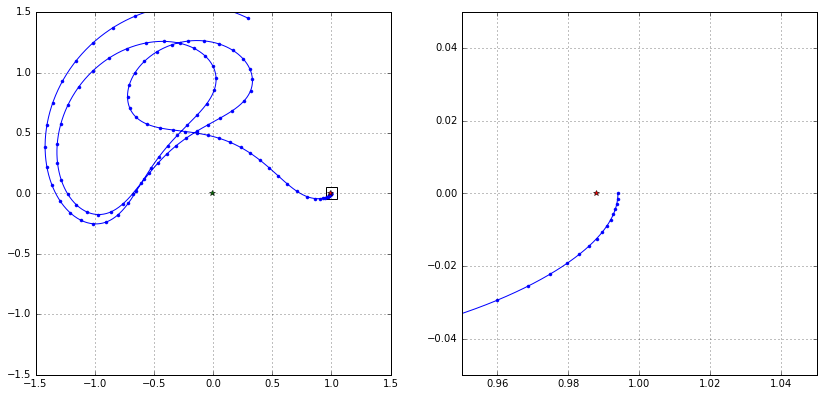

In [10]:
T, Y = adaptive_stepsize(aren, aren_init, aren_tmax, euler, 1e-4)
orbit_plot(Y, skip=20) # Отмечаем точкой каждый 20й шаг

Явный метод средней точки, всего шагов: 563, отброшено: 5


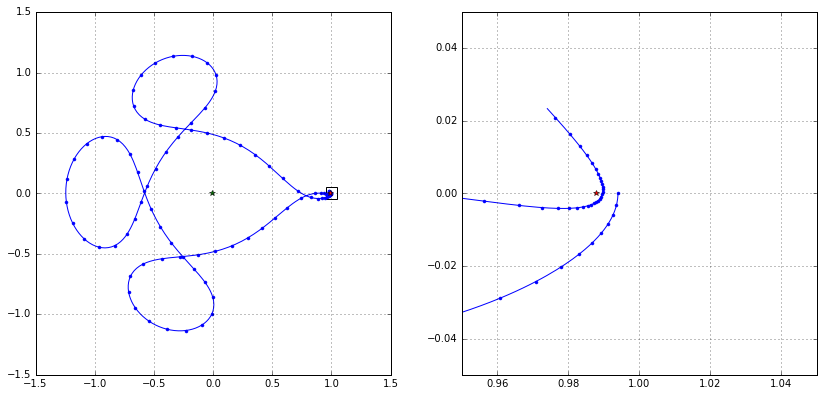

In [11]:
T, Y = adaptive_stepsize(aren, aren_init, aren_tmax, midpoint, 1e-4)
orbit_plot(Y, skip=5) # Отмечаем точкой каждый 5й шаг

Классический метод РК 4 порядка, всего шагов: 117, отброшено: 16


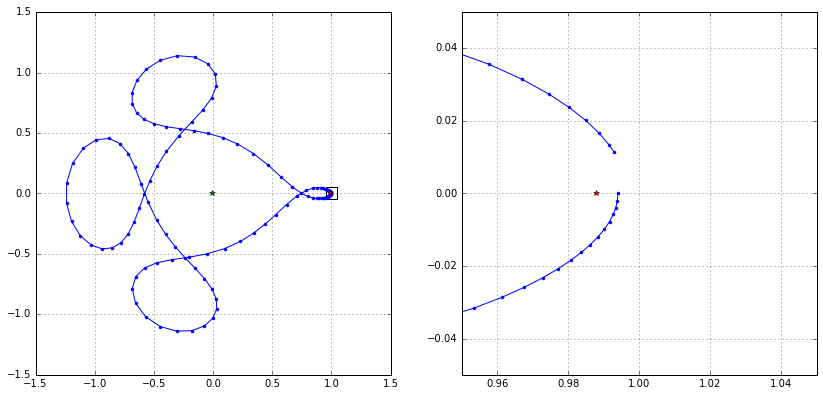

In [12]:
T, Y = adaptive_stepsize(aren, aren_init, aren_tmax, rk4, 1e-4)
orbit_plot(Y, skip=1) # Отмечаем точкой каждый шаг

Классический метод РК 4 порядка, всего шагов: 5001


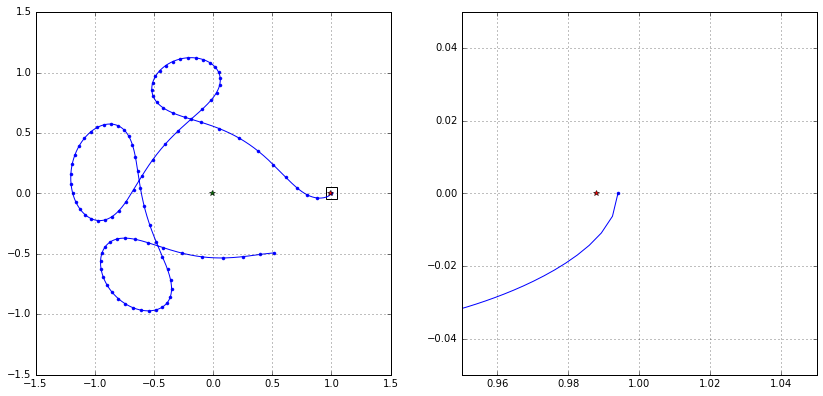

In [13]:
T, Y = fixed_stepsize(aren, aren_init, aren_tmax, rk4, aren_tmax/5000)
orbit_plot(Y, skip=50) # Отмечаем точкой каждый 50й шаг

### Жесткие задачи

Жесткие системы ОДУ описывают, как правило, одновременно проходящие очень быстрые и очень медленные процессы. 
Например, в задачах химической кинетики бывают различия в скоростях реакций до $10^{15}$ раз.

Оказывается, что быстро протекающие процессы, даже быстро закончившись, продолжают влиять на численное решение задачи, вынуждая рассчитывать решение с очень малым шагом по времени, где это, казалось бы, совершенно не требуется (решение довольно гладкое).

### Пример жесткой задачи из хим. кинетики
Рассмотрим две реакции
$$
\mathrm{X} \overset{\text{slow}}{\to} \mathrm{Z}\\
\mathrm{Y} \overset{\text{fast}}{\to} \mathrm{X},
$$
причем первая &mdash; медленная, а вторая &mdash; быстрая.
$$
\frac{dx}{dt} = -0.5 x + 30y\\
\frac{dy}{dt} = -30y\\
$$

In [14]:
def chem(t, u):
    x, y = u
    return np.array([-0.5*x+30*y, -30*y])

chem_init = np.array([0, 1])
chem_tmax = 5

Явный метод Эйлера, всего шагов: 92, отброшено: 6
Явный метод Эйлера, всего шагов: 15, отброшено: 0


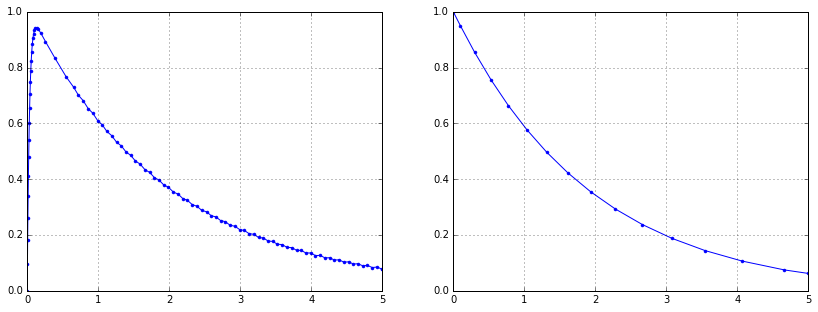

In [15]:
T, Y = adaptive_stepsize(chem, chem_init, chem_tmax, euler, 1e-2)
T2, Y2 = adaptive_stepsize(lambda t,u:-0.5*u, np.array([1]), chem_tmax, euler, 1e-2)
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1); plt.plot(T, Y[:, 0], '.-'); plt.grid(); 
plt.subplot(1,2,2); plt.plot(T2, Y2[:, 0], '.-') # <<похожая>> задача
plt.grid(); plt.show()

### Ручное управление шагом

Попробуем руками увеличить шаг в "гладкой" области.

Явный метод Эйлера, всего шагов: 25, отброшено: 3
Явный метод Эйлера, всего шагов: 57


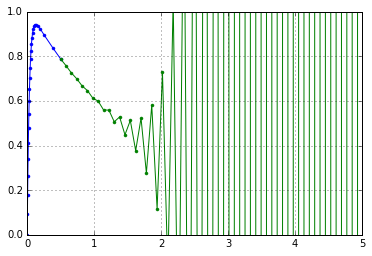

In [16]:
T1, Y1 = adaptive_stepsize(chem, chem_init, 0.5, euler, 1e-2)
T2, Y2 = fixed_stepsize(chem, Y1[-1,:], chem_tmax-0.5, euler, 0.08)
plt.plot(T1, Y1[:, 0], '.-')
plt.plot(T2+0.5, Y2[:, 0], '.-')
plt.axis([0, 5, 0, 1])
plt.grid(); plt.show()

### Жесткая устойчивость

Решение выглядит как неустойчивое. Но сам метод устойчив (как любой метод Рунге-Кутты) и при уменьшении шага этот эффект пропадает. Все явные методы подвержены этой проблеме &mdash; они продолжают чувствовать быстрые процессы даже после того, как они прекращают существенно влиять на решение. 

Однако, некоторые неявные методы вполне хорошо такие задачи решают. Такие методы называют А-устойчивыми.

In [17]:
def newton(F, dFdx, x0):
    x = x0.copy()
    for it in range(50):
        dx = np.linalg.solve(dFdx(x), F(x))
        x -= dx
        if np.linalg.norm(dx) < 1e-12:
            return x
    print('Максимальное число итераций превышено!')
    return x

In [18]:
def imeuler(f, h, t, u):
    E = np.eye(len(u))
    k1 = newton(
        lambda k: k - f(t+h, u+h*k), # Уравнение k-f(t+h,u+h*k) = 0
        lambda k: E - h*f(t+h, u+h*k, jac=True), # Производная по k
        f(t, u)) # Начальное приближение
    return u + h*k1
imeuler.order=1; imeuler.name='Неявный Эйлер'

def immidpoint(f, h, t, u):
    E = np.eye(len(u))
    k1 = newton(
        lambda k: k - f(t+h/2, u+h/2*k), # Уравнение k-f(t+h/2,u+h/2*k) = 0
        lambda k: E - h*f(t+h/2, u+h/2*k, jac=True), # Производная по k
        f(t, u)) # Начальное приближение
    return u + h*k1
immidpoint.order=2; immidpoint.name='Неявная средняя точка'

In [19]:
# Добавим вычисление производной, необходимой для метода Ньютона
def chem(t, u, jac=False):
    x, y = u
    if jac:
        return np.array([[-0.5, 30], [0, -30]])
    return np.array([-0.5*x+30*y, -30*y])

Неявный Эйлер, всего шагов: 34, отброшено: 3


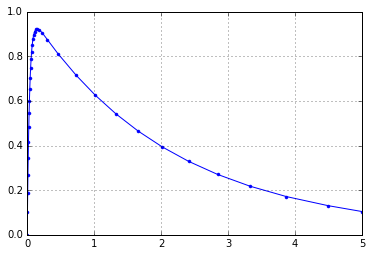

In [20]:
T, Y = adaptive_stepsize(chem, chem_init, chem_tmax, imeuler, 1e-2)
plt.plot(T, Y[:, 0], '.-')
plt.grid(); plt.show()

Неявная средняя точка, всего шагов: 16, отброшено: 2


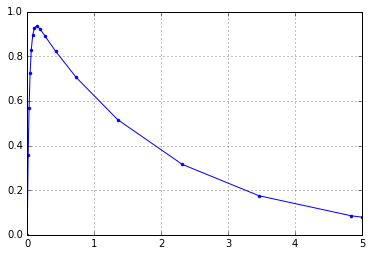

In [21]:
T, Y = adaptive_stepsize(chem, chem_init, chem_tmax, immidpoint, 1e-2)
plt.plot(T, Y[:, 0], '.-')
plt.grid(); plt.show()

### Счет всюду с большим шагом
Оказывается, для некоторых методов даже необязательно измельчать шаг в области быстрых процессов! Если точность не критична, а необходимо просто получить качественную картину процесса, эти методы могут быть удобны.

Такие методы называются L-устойчивыми.

Неявный Эйлер, всего шагов: 25


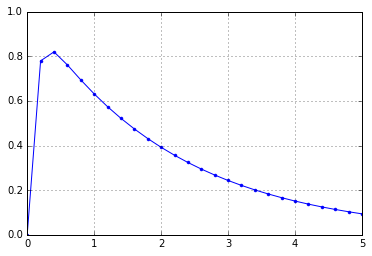

In [22]:
T, Y = fixed_stepsize(chem, chem_init, chem_tmax, imeuler, 0.2)
plt.plot(T, Y[:, 0], '.-')
plt.ylim(0, 1)
plt.grid(); plt.show()

Неявная средняя точка, всего шагов: 25


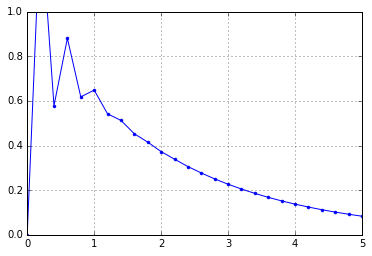

In [23]:
T, Y = fixed_stepsize(chem, chem_init, chem_tmax, immidpoint, 0.2)
plt.plot(T, Y[:, 0], '.-')
plt.ylim(0, 1)
plt.grid(); plt.show()

### Возмущения решения
Расмотрим решение $\mathbf y(t)$, удовлетворяющее системе
$\frac{d\mathbf y(t)}{dt} = \mathbf G(t, \mathbf y(t))$.

Пусть $\mathbf y(t) + \boldsymbol \epsilon(t)$ &mdash; близкое решение той же системы. Тогда в первом приближении
отклонение $\boldsymbol \epsilon(t)$ удовлетворяет линейному дифференциальному уравнению
$$
\frac{d\boldsymbol \epsilon(t)}{dt} = \mathbf A(t) \boldsymbol \epsilon(t), \qquad
\mathbf A(t) = \frac{\partial \mathbf G}{\partial \mathbf y}(t, \mathbf y(t)).
$$ 

### Модельное уравнение для возмущения
Понять, как ведет себя решение
$$
\frac{d\boldsymbol \epsilon(t)}{dt} = \mathbf A(t) \boldsymbol \epsilon(t),
$$
можно рассматривая совокупность модельных скалярных уравнений
$$
\frac{d\epsilon}{dt} = \lambda \epsilon, \qquad \lambda \in \lambda(\mathbf A).
$$
Таким образом, о поведении возмущений трактории в задаче можно судить по *спектру матрицы Якоби системы*.

### Спектр жесткой задачи
В спектре матрицы Якоби жесткой системы ОДУ можно выделить две зоны
<img src="sp.png" style="height:300px">

Отношение $L/\ell \gg 1$ называется *показателем жесткости задачи*.

### Решение жесткой задачи явным методом Эйлера
<img src="instab.png" style="height:400px">

### Проверка метода на жесткую устойчивость
Чтобы понять, годится ли тот или иной метод для решения жесткой задачи, необходимо применить его к модельному уравнению
$$
\frac{dy}{dt} = \lambda y, \qquad \lambda \in \mathbb C,\; \operatorname{Re} \lambda < 0,
$$
и посмотреть, будет ли решение затухать (отклонение от траектории будут уменьшаться) или, наоборот, расти (отклонение будет увеличиваться).

### Функция устойчивости
Оказывается, что применение любого одношагового метода (например, любого метода Рунге-Кутты) к $y' = \lambda y$ дает следующий численный метод:
$$
u_{n+1} = r(\lambda \tau) u_n,
$$
где $r(z)$ &mdash; функция, зависящая только от самого метода. Эта функция называется *функцией устойчивости* данного метода. Легко видеть, что условие $|r(\lambda \tau)| \leqslant 1$ гарантирует отсутствие развития неустойчивости. Область значений $z$, где $|r(z)| \leqslant 1$ называется *областю устойчивости метода*.

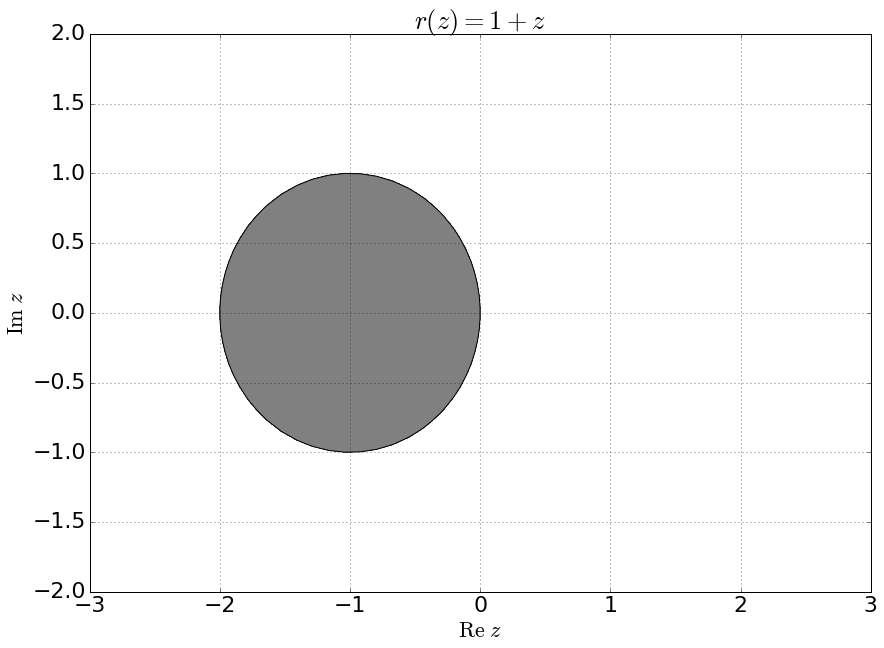

In [67]:
X,Y = np.meshgrid(np.linspace(-3, 3), np.linspace(-2, 2))
Z = X + 1j * Y
plt.figure(figsize=(14, 10))
plt.rc('font', size=22)
plt.contour(X, Y, np.abs(1 + Z), [1], colors='k')
plt.contourf(X, Y, np.abs(1 + Z), [0, 1], colors='gray')
plt.xlabel('${\\rm Re}\; z$')
plt.ylabel('${\\rm Im}\; z$')
plt.title('$r(z) = 1+z$')
plt.grid()

### Область устойчивости и спектр задачи
Для того, чтобы численный метод был жестко устойчив для данной задачи требуется, чтобы все жесткие собственные числа $\lambda_i$ задачи попали после умножения на $\tau$ в область устойчивости.

<img src="spst.png" style="height:300px">

### Функция устойчивости метода Рунге-Кутты
Для методов Рунге-Кутты существует удобная формула, выражающая $r(z)$ через коэффициенты таблицы Бутчера.
$$
\begin{array}{c|c}
c&A\\
\hline
&b
\end{array}
\qquad
r(z) = \frac{\det(E - zA + zB)}{\det(E - zA)},
\qquad 
B = \begin{pmatrix}1\\1\\\vdots\\1\end{pmatrix}
b = \begin{pmatrix}
b_1 & b_2 & \dots & b_n\\
b_1 & b_2 & \dots & b_n\\
{}&&\vdots\\
b_1 & b_2 & \dots & b_n
\end{pmatrix}
$$

### Свойства функции устойчивости
Для метода Рунге-Кутты с $s$ стадиями
$$
r(z) = \frac{P_s(z)}{Q_s(z)},
$$
где $P_s(z), Q_s(z)$ &mdash; многочлены степени не больше $s$. Если метод явный, то $Q_s(z) = 1$.

### Свойства функции устойчивости
Сравним точное решение модельного уравнения
$$
[y]_{n+1} = e^{\lambda \tau} [y]_n
$$
и численное решение
$$
u_{n+1} = r(\lambda \tau) u_n.
$$
Условие сходимости порядка $p$: $\max_{n} |[y]_n - u_n| = O(\tau^p)$ влечет 
$$
r(z) = e^z + O(z^{p+1})
$$

### Классификация методов по функции устойчивости
Если область устойчивости содержит левую комплексную полуплоскость
$
\mathbb C^{-} = \left\{z \mid \operatorname{Re} z < 0\right\},
$
метод называется A-устойчивым (подходит для всех жестких задач).

Если область устойчивости содержит конус $\left\{z \mid \left|\frac{\pi}{2} - \arg z\right| < \alpha\right\}$,
метод называется A$(\alpha)$-устойчивым (подходит для жестких задач, у которых жесткий спектр содержится в таком же конусе).

Если метод A-устойчив и дополнительно
$
\lim\limits_{z \to -\infty} r(z) = 0,
$
метод называется L-устойчивым. Позволяет интегрировать с большим шагом даже участки, где быстрые процессы еще не закончились, качественно повторяя картину решения.